## Importing the necessary Python libraries

In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, tree
from sklearn.linear_model import LogisticRegression, SGDClassifier

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.feature_selection import chi2

## Importing the .csv files

In [2]:
train_values = pd.read_csv('Richters_Predictor_Modeling_Earthquake_Damage_-_Train_Values.csv')
train_labels = pd.read_csv('Richters_Predictor_Modeling_Earthquake_Damage_-_Train_Labels.csv')
test_values = pd.read_csv('Richters_Predictor_Modeling_Earthquake_Damage_-_Test_Values.csv')

In [3]:
train_values.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,6,487,12198,2,30,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
1,28830,8,900,2812,2,10,8,7,o,r,...,0,0,0,0,0,0,0,0,0,0
2,94947,21,363,8973,2,10,5,5,t,r,...,0,0,0,0,0,0,0,0,0,0
3,590882,22,418,10694,2,10,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
4,201944,11,131,1488,3,30,8,9,t,r,...,0,0,0,0,0,0,0,0,0,0


In [4]:
train_values.describe()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
count,2.606010e+05,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,...,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000
mean,5.256755e+05,13.900353,701.074685,6257.876148,2.129723,26.535029,8.018051,5.434365,0.088645,0.761935,...,0.064378,0.033626,0.008101,0.000940,0.000361,0.001071,0.000188,0.000146,0.000088,0.005119
std,3.045450e+05,8.033617,412.710734,3646.369645,0.727665,73.565937,4.392231,1.918418,0.284231,0.425900,...,0.245426,0.180265,0.089638,0.030647,0.018989,0.032703,0.013711,0.012075,0.009394,0.071364
min,4.000000e+00,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.611900e+05,7.000000,350.000000,3073.000000,2.000000,10.000000,5.000000,4.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.257570e+05,12.000000,702.000000,6270.000000,2.000000,15.000000,7.000000,5.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.897620e+05,21.000000,1050.000000,9412.000000,2.000000,30.000000,9.000000,6.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.052934e+06,30.000000,1427.000000,12567.000000,9.000000,995.000000,100.000000,32.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Checking out the geographic level distribution

<Axes: xlabel='geo_level_3_id', ylabel='Count'>

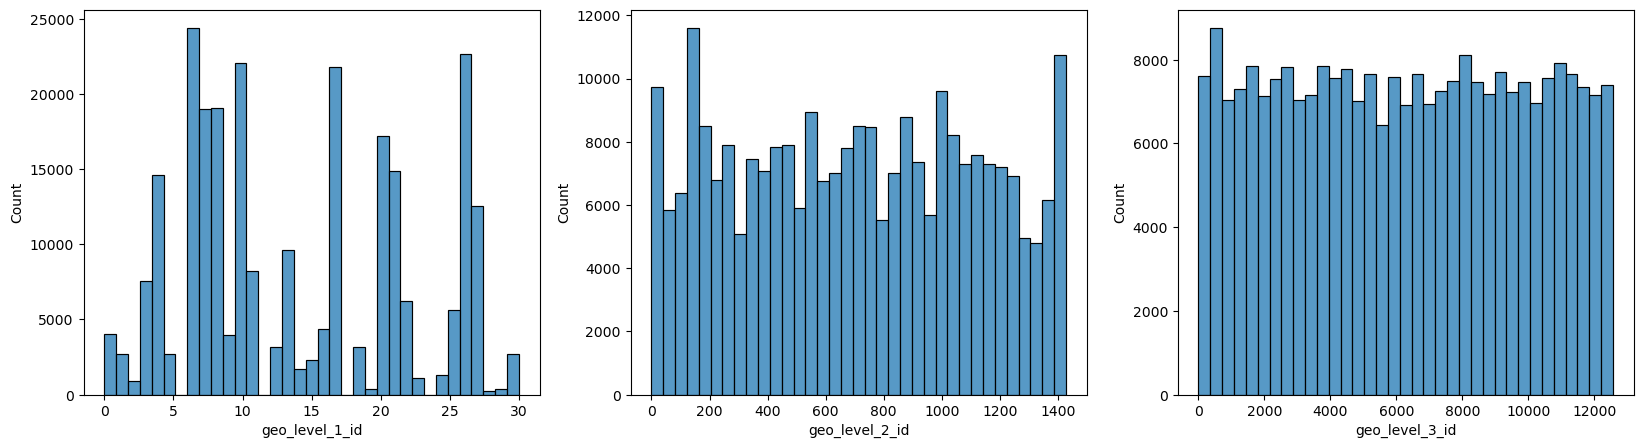

In [5]:
figure, axes = plt.subplots(1, 3, sharex=False, figsize=(20, 5))
sns.histplot(train_values['geo_level_1_id'], bins=35, ax=axes[0])
sns.histplot(train_values['geo_level_2_id'], bins=35, ax=axes[1])
sns.histplot(train_values['geo_level_3_id'], bins=35, ax=axes[2])

In [23]:
labels = train_labels.iloc[:,1]
one_thing = pd.concat([train_values, labels], axis=1)

## Plotting the destruction level based on geographic location and the age of the building.

### At first sight, we can see that the 3rd, 11th and 27th area affected most by the earthquake.

<Axes: xlabel='geo_level_1_id', ylabel='age'>

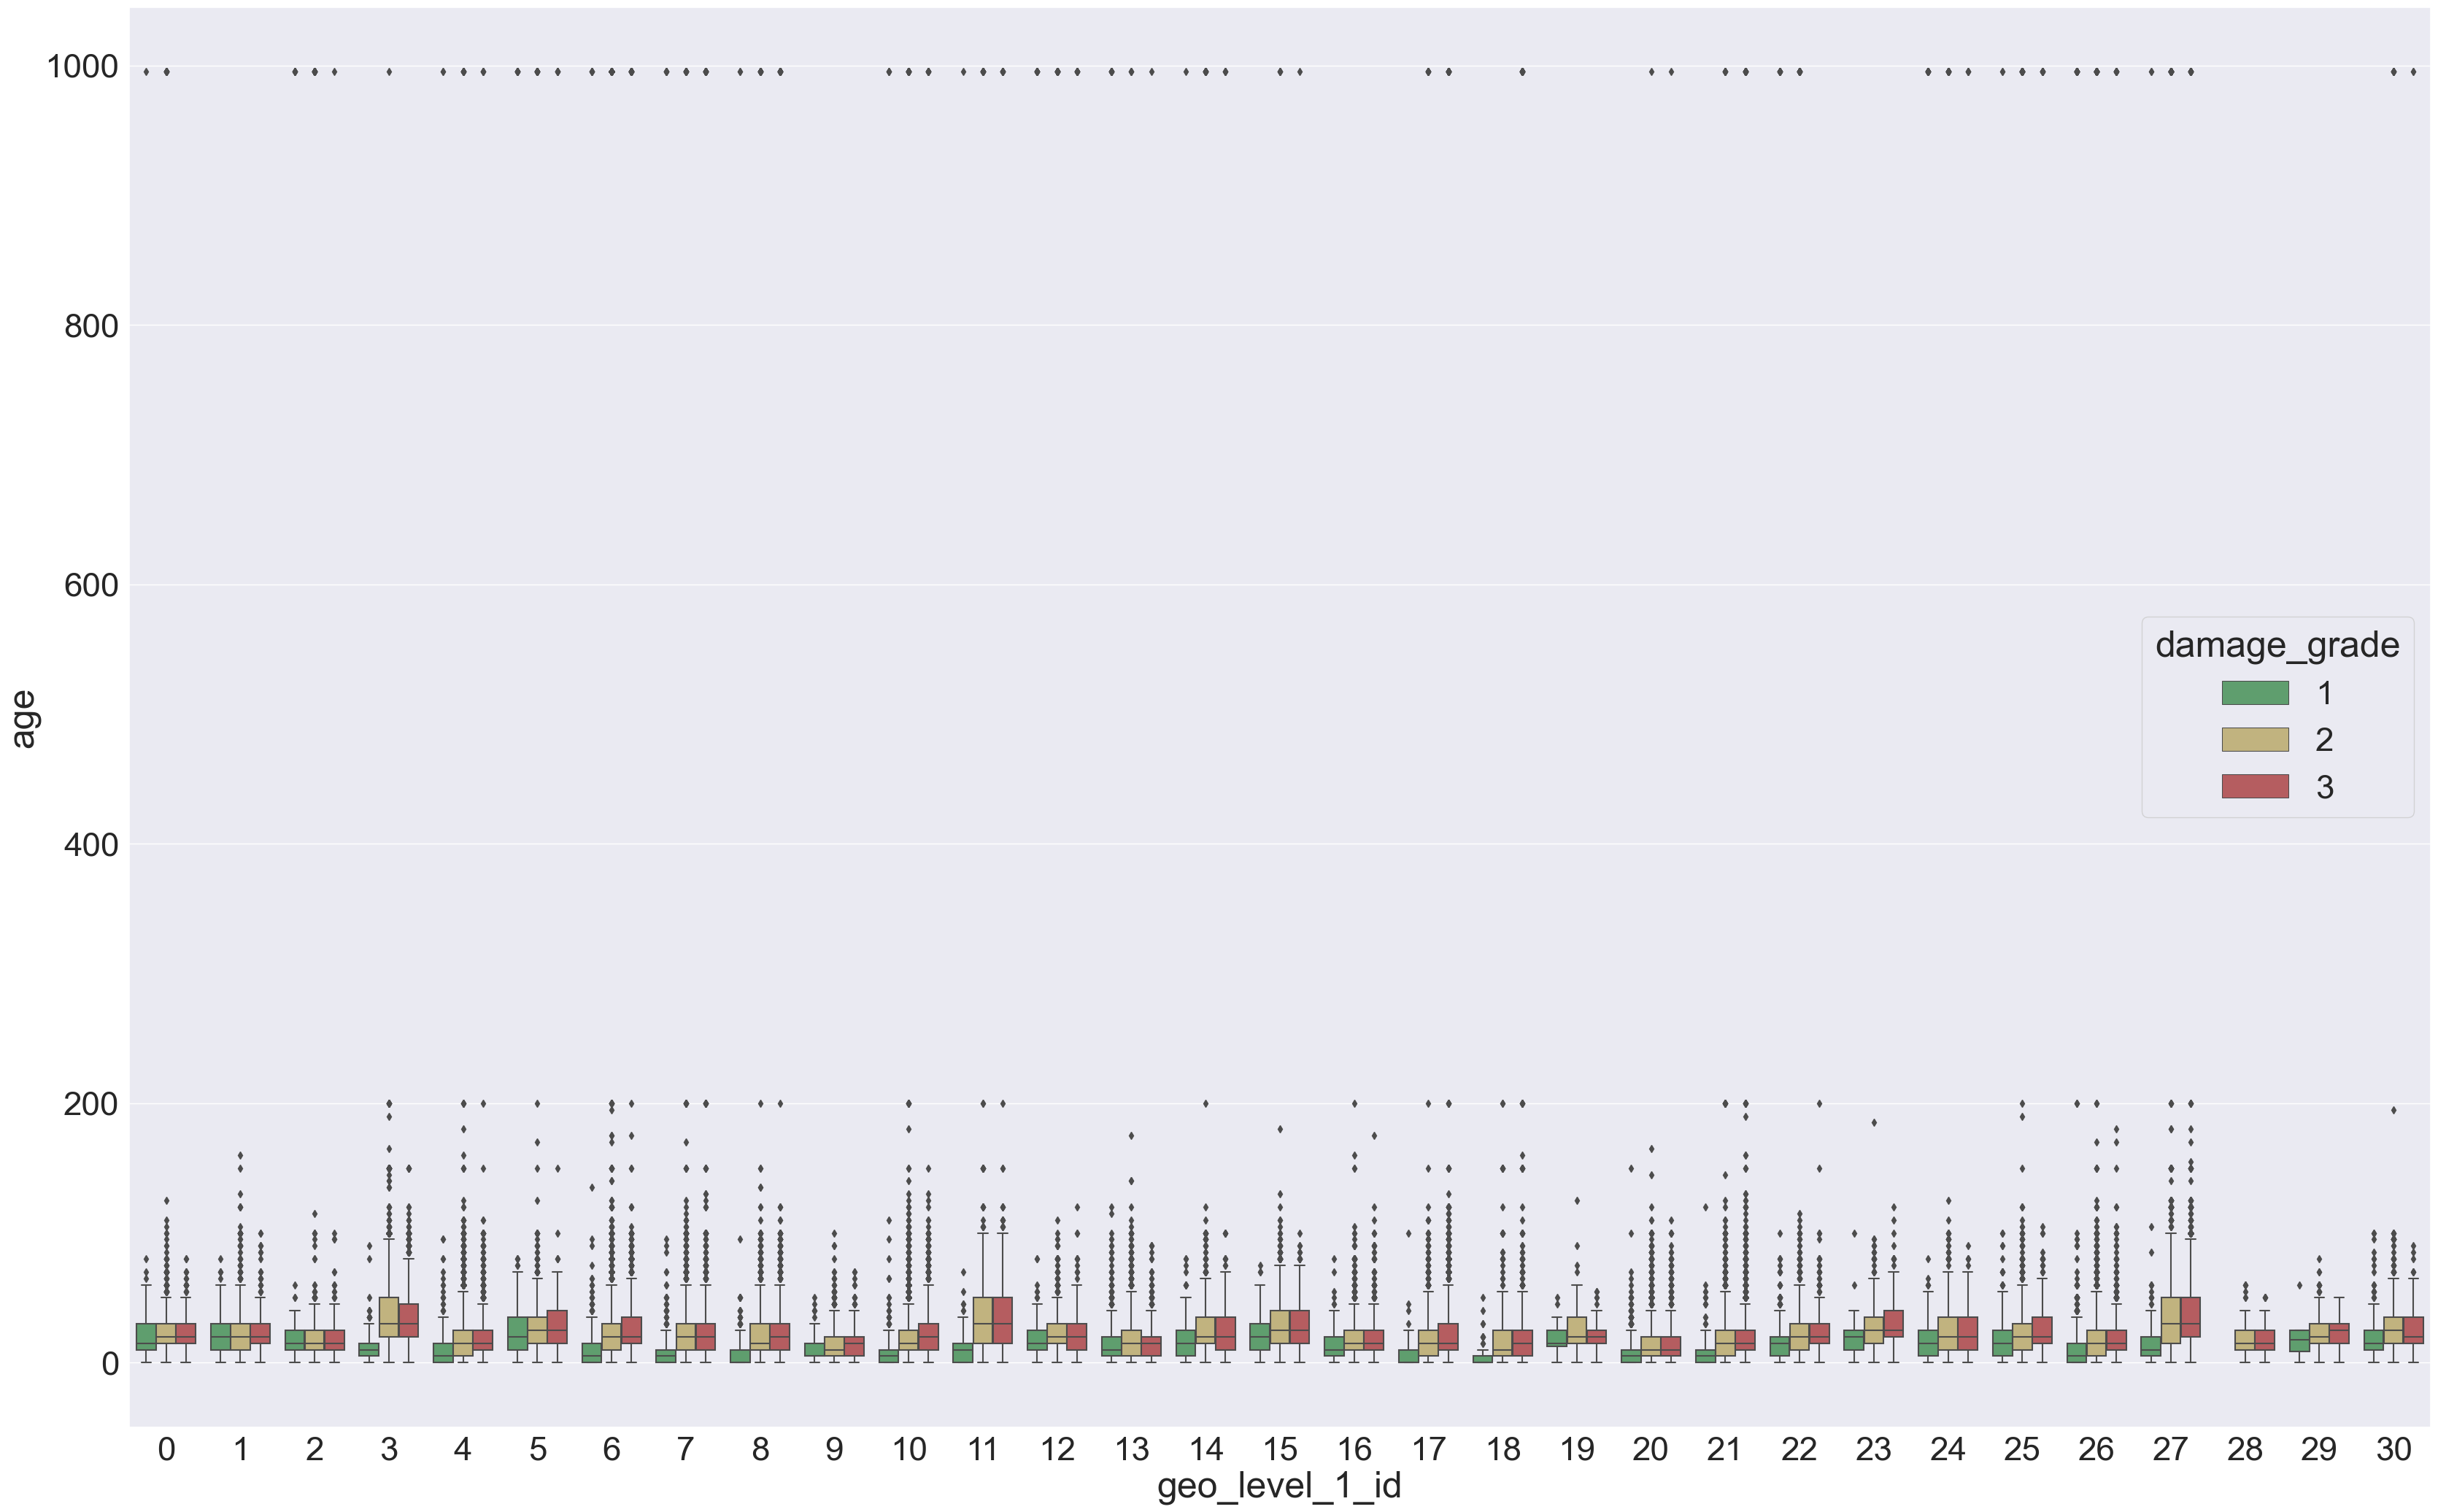

In [7]:
sns.set_theme(style="ticks", palette="pastel")
sns.set(rc={'figure.figsize':(40.7,25.27)}, font_scale=3)
#sns.set(font_scale = 2)
sns.boxplot(x="geo_level_1_id", y="age",
            hue="damage_grade", palette=["g", "y", "r"],
            data=one_thing)

#sns.despine(offset=10, trim=True)

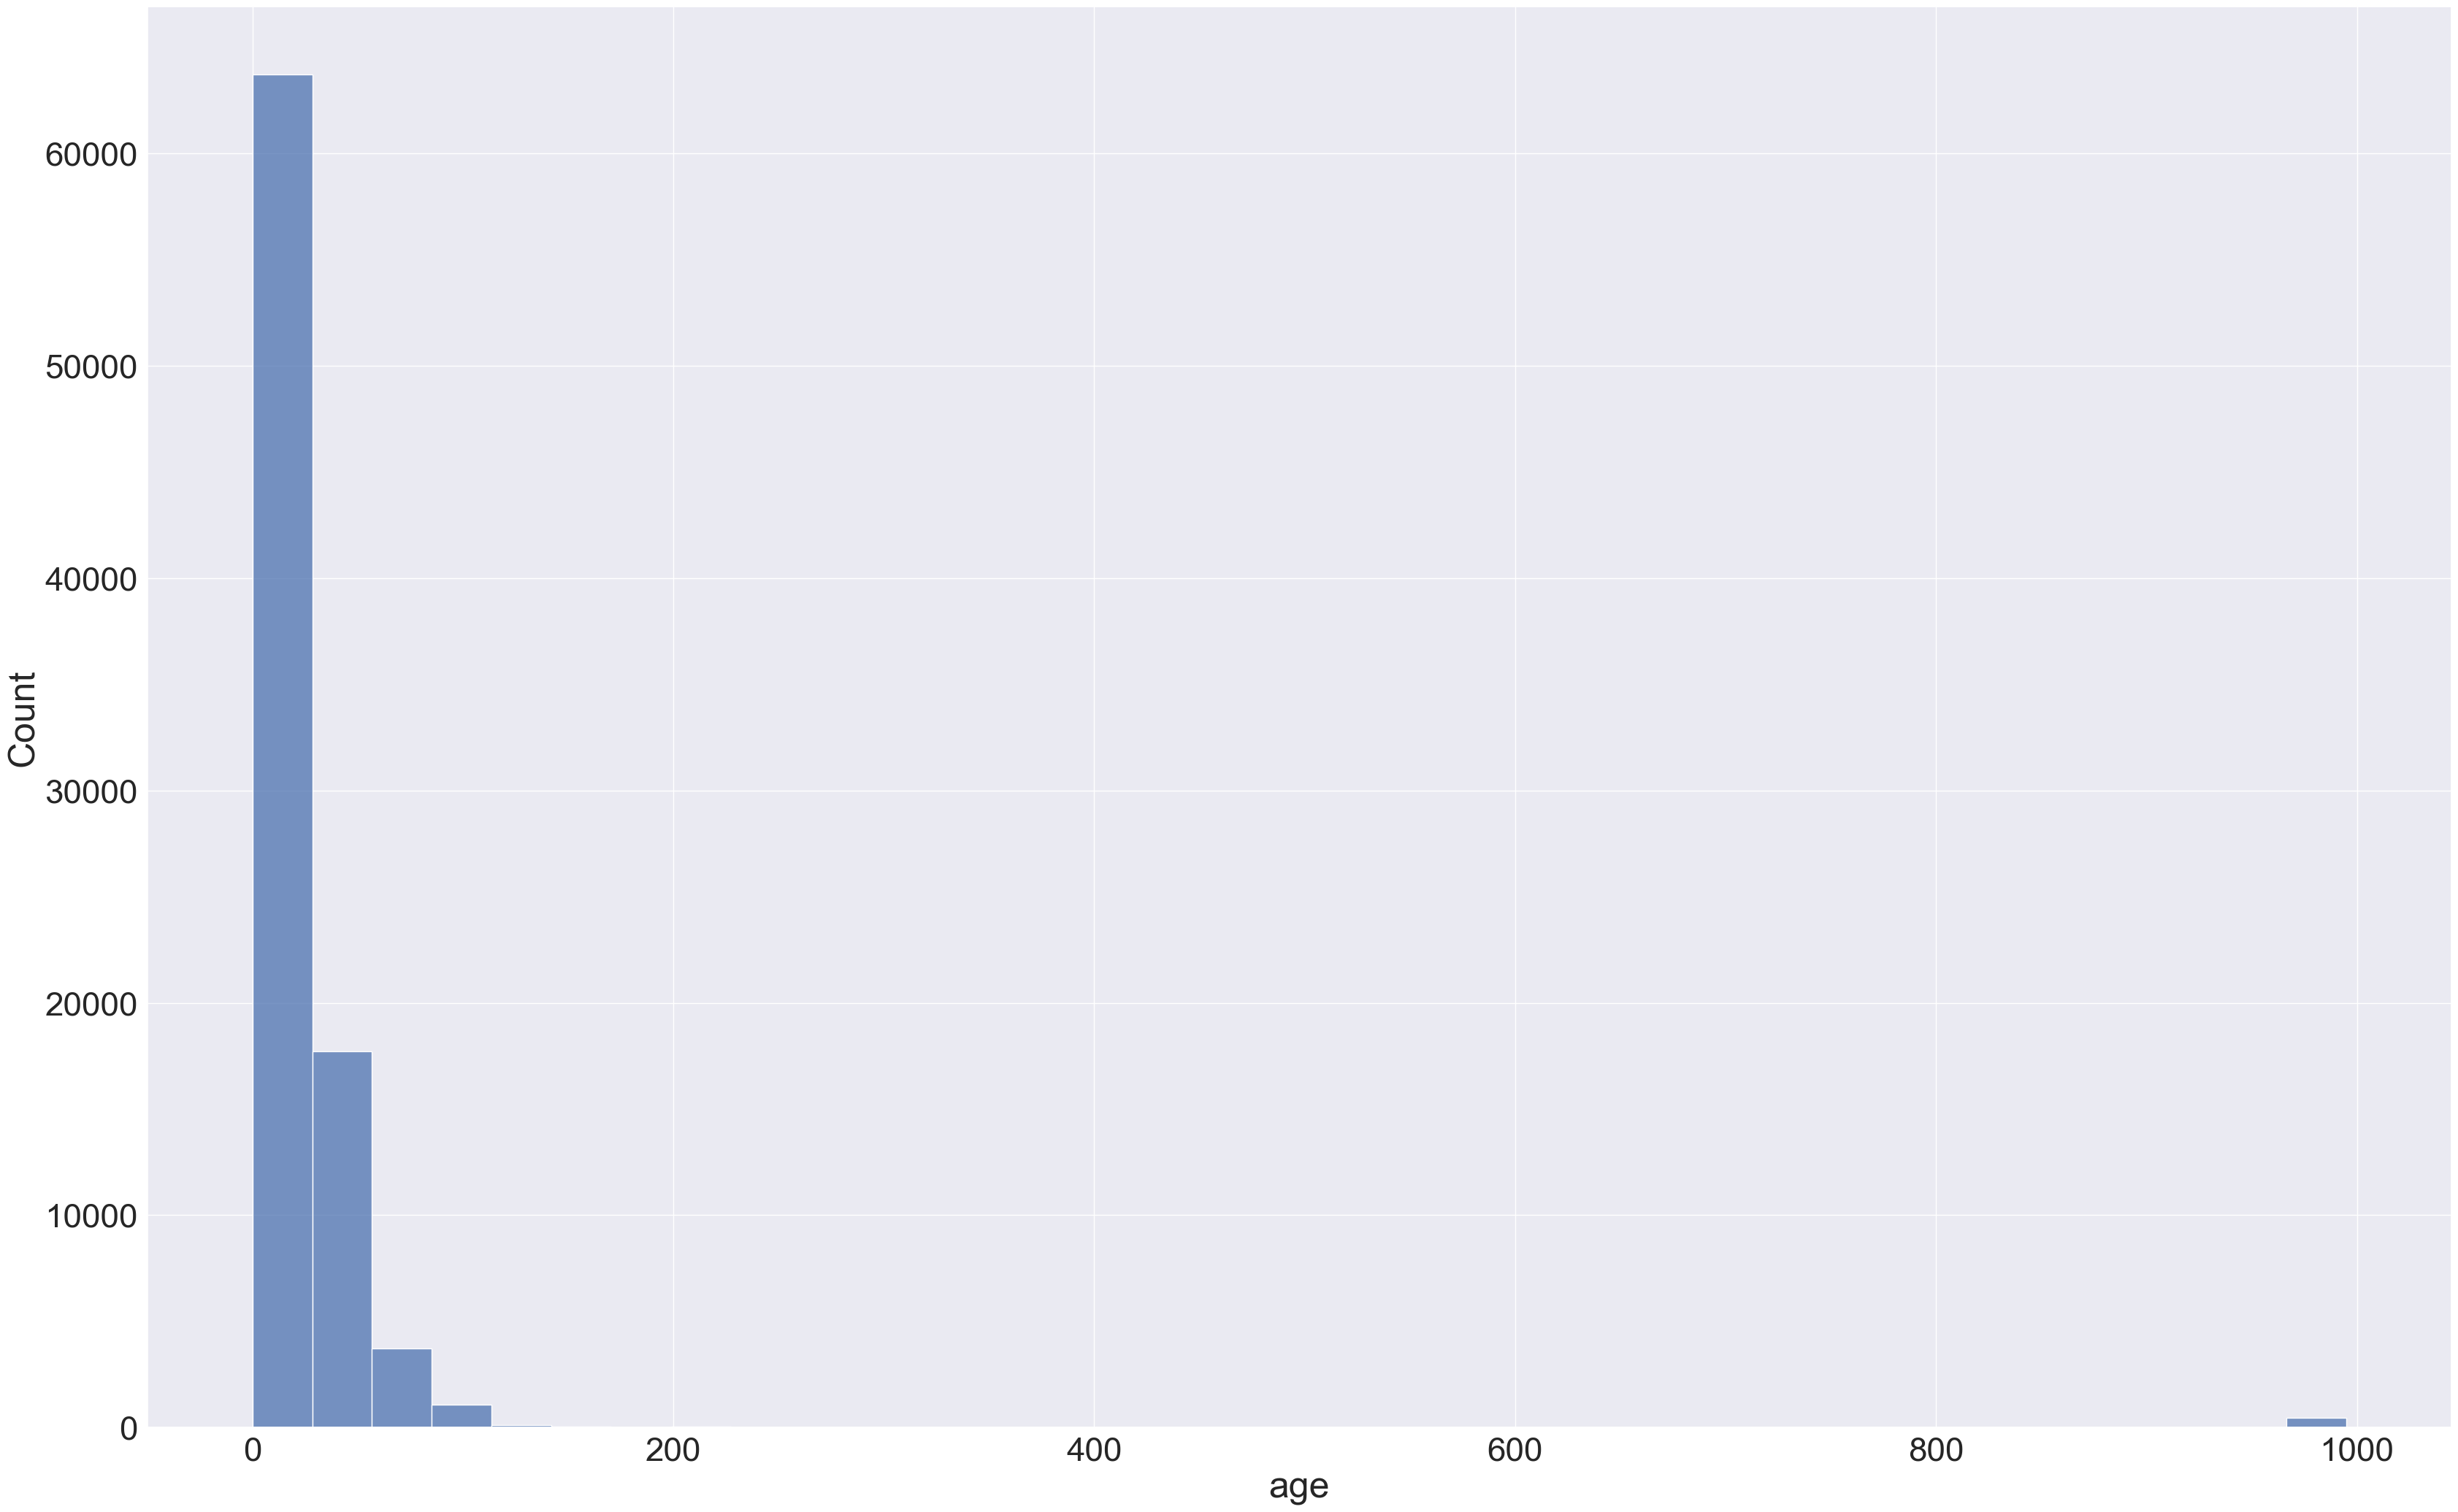

In [8]:
sns.histplot(test_values['age'], bins=35)
scaler = StandardScaler()
train_values['age'] = scaler.fit_transform(np.array(train_values['age']).reshape(-1,1))
#sns.histplot(train_values['age'], bins=35)
building_id = test_values['building_id']

secondary = ['has_secondary_use_agriculture', 'has_secondary_use_hotel',
            'has_secondary_use_rental', 'has_secondary_use_institution',
            'has_secondary_use_school', 'has_secondary_use_industry',
            'has_secondary_use_health_post', 'has_secondary_use_gov_office',
            'has_secondary_use_use_police', 'has_secondary_use_other',
            'has_secondary_use']

binary_values = ['has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone',
                'has_superstructure_stone_flag', 'has_superstructure_cement_mortar_stone',
                'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick',
                'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_other']

categorical = ['land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type',
               'other_floor_type', 'position', 'plan_configuration']

drop_columns = ['building_id', 'legal_ownership_status', 'count_floors_pre_eq', 'has_secondary_use_use_police']
train_values = train_values.drop(drop_columns, axis=1)

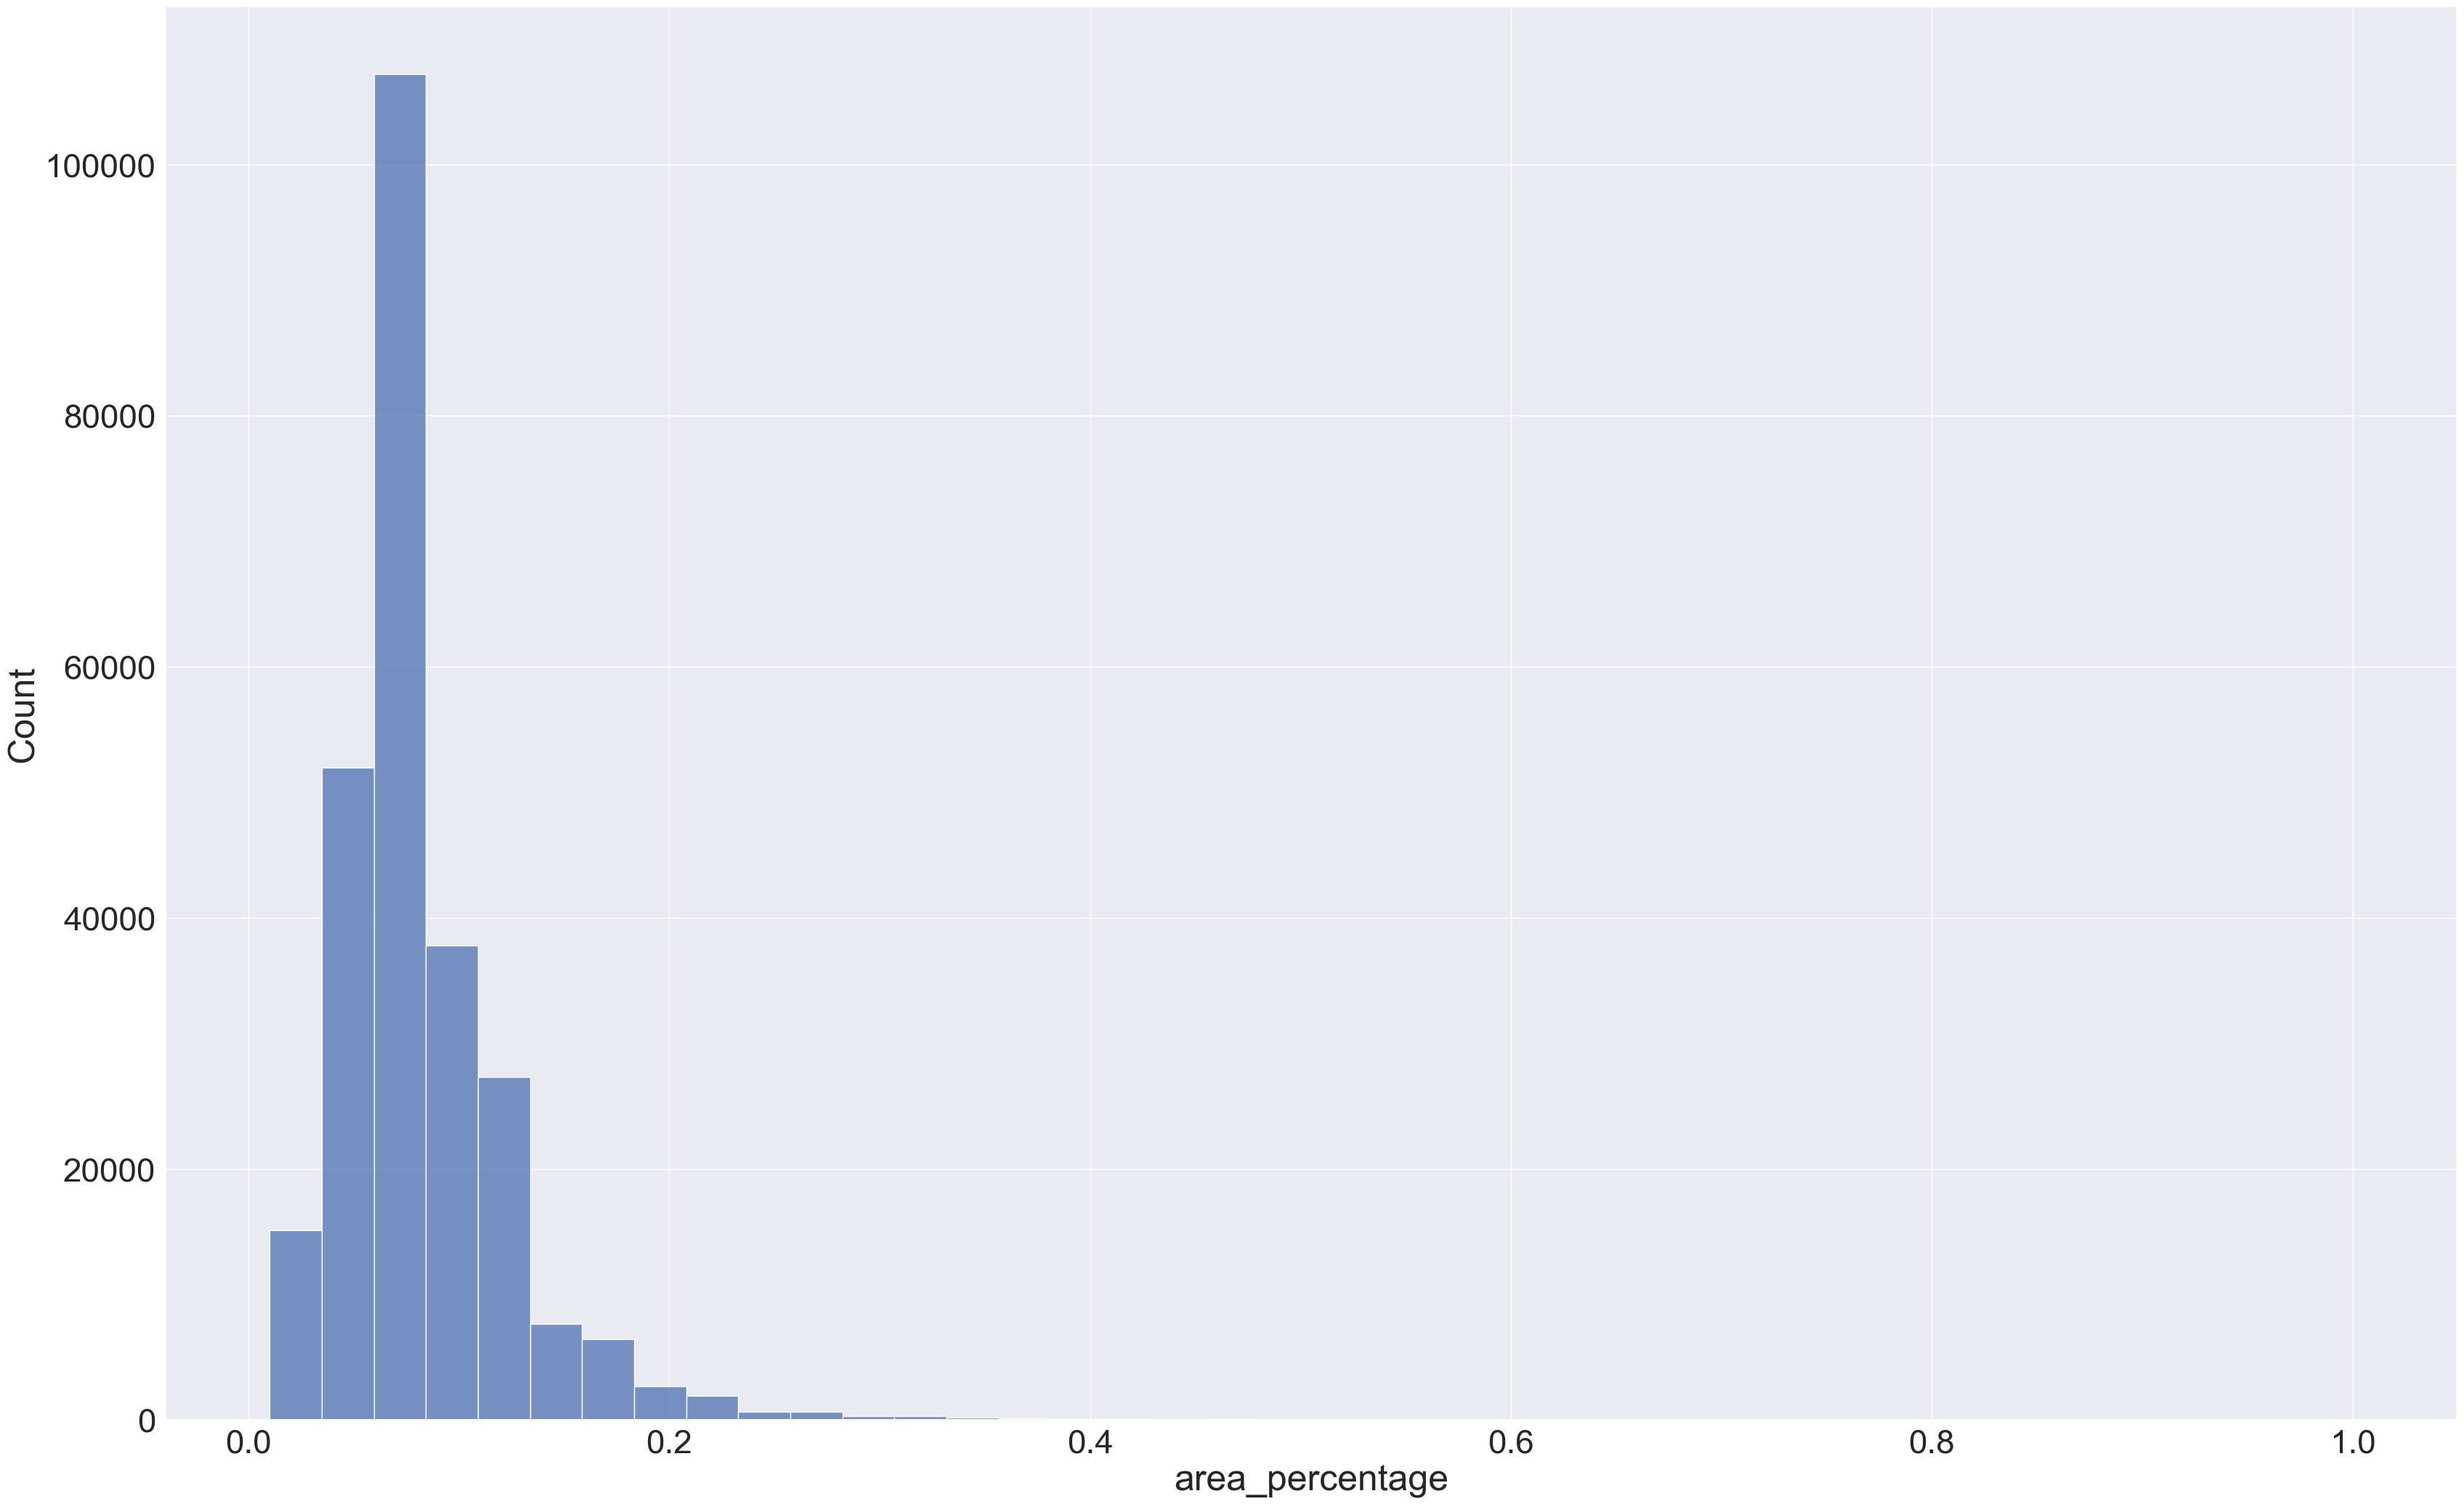

In [9]:
#SCALING THE AGE (EXPERIMENTAL)
scaler = MinMaxScaler()
train_values['age'] = scaler.fit_transform(np.array(train_values['age']).reshape(-1,1))
test_values['age'] = scaler.fit_transform(np.array(test_values['age']).reshape(-1,1))

#Concat Area (EXPERIMENTAL)
train_values['plan_configuration'] = ['d' if plan in ['s', 'c', 'a', 'o', 'm', 'n', 'f'] else plan for plan in train_values['plan_configuration']]
train_values['foundation_type'] = ['i' if foundation == 'h' else foundation for foundation in train_values['foundation_type']]

train_values['height_percentage'] = [height/100 for height in train_values['height_percentage']]
train_values['area_percentage'] = [area/100 for area in train_values['area_percentage']]

sns.histplot(train_values['area_percentage'], bins=40)

categorical_df = ['land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type',
                  'other_floor_type', 'position', 'plan_configuration']

In [10]:
ohe = OneHotEncoder(sparse_output=False)   
le = LabelEncoder() 
encoded_dataframe = pd.DataFrame()
for i in categorical_df:
    temporary = pd.DataFrame(ohe.fit_transform(np.array(train_values[i]).reshape(-1, 1)))
    temporary.columns = ohe.get_feature_names_out([i])
    encoded_dataframe = pd.concat([encoded_dataframe, temporary], axis=1)
    train_values.drop([i], axis=1, inplace=True)   
    
x = pd.concat([train_values, encoded_dataframe], axis=1)
y = le.fit_transform(train_labels['damage_grade'])

In [11]:
#Finding the correlation between two columns. If it's higher than 70%, then one of them will be dropped.    
def find_high_correlation_columns(df):
    le = LabelEncoder()
    for i in df.columns:
        for j in df.columns:
            if i == j:
                pass
            else:
                if (type(df[i][1]) != str) and (type(df[j][1]) != str):
                    if df[i].corr(df[j])*100 > 70:
                        print(i, j, df[i].corr(df[j])*100)
                elif type(df[i][1]) != str and (type(df[j][1]) == str):
                    if df[i].corr(pd.DataFrame(le.fit_transform(df[j]))[0])*100 > 70:
                        print(i, j, df[i].corr(pd.DataFrame(le.fit_transform(df[j]))[0])*100)
                elif type(df[i][1]) == str and (type(df[j][1]) != str):
                    if df[j].corr(pd.DataFrame(le.fit_transform(df[i]))[0])*100 > 70:
                        print(i, j, df[j].corr(pd.DataFrame(le.fit_transform(df[i]))[0])*100)
                else:
                    if pd.DataFrame(le.fit_transform(df[j]))[0].corr(pd.DataFrame(le.fit_transform(df[i]))[0])*100 > 70:
                        print(i, j, pd.DataFrame(le.fit_transform(df[j]))[0].corr(pd.DataFrame(le.fit_transform(df[i]))[0])*100)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

test_values = test_values.drop(drop_columns, axis=1)

In [13]:
#Concat Area (EXPERIMENTAL)
test_values['plan_configuration'] = ['d' if plan in ['s', 'c', 'a', 'o', 'm', 'n', 'f'] else plan for plan in test_values['plan_configuration']]
test_values['foundation_type'] = ['i' if foundation == 'h' else foundation for foundation in test_values['foundation_type']]

test_values['height_percentage'] = [height/100 for height in test_values['height_percentage']]
test_values['area_percentage'] = [area/100 for area in test_values['area_percentage']]

In [14]:
ohe_ = OneHotEncoder(sparse_output=False)   

encoded_test_dataframe = pd.DataFrame()

In [15]:
for i in categorical_df:
    temporary_test = pd.DataFrame(ohe_.fit_transform(np.array(test_values[i]).reshape(-1, 1)))
    temporary_test.columns = ohe_.get_feature_names_out([i])
    encoded_test_dataframe = pd.concat([encoded_test_dataframe, temporary_test], axis=1)
    test_values.drop([i], axis=1, inplace=True)   
    
p = pd.concat([test_values, encoded_test_dataframe], axis=1)

In [16]:
xgb = XGBClassifier(objective='multi:softmax', gamma=0, alpha=0.1, max_depth=10,
                    colsample_bytree=0.8, subsample=0.8)

In [17]:
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
score = f1_score(y_test, y_pred, average='micro')
print(score)

0.7439803534084152


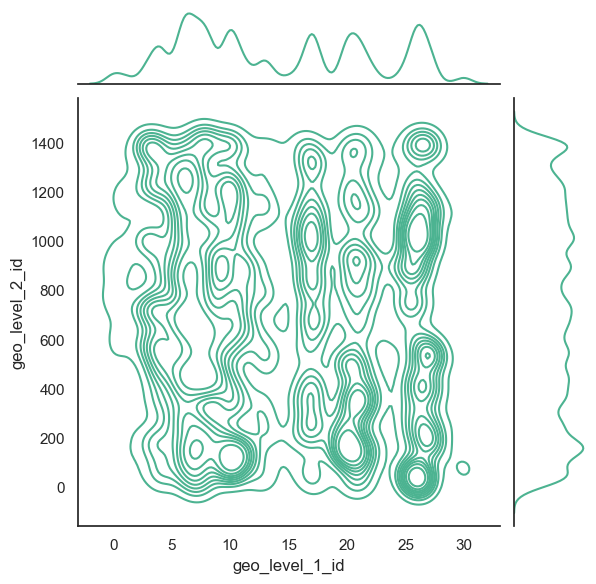

In [18]:
# Plot the geo_levels
sns.set_theme(style='white')
sns.jointplot(x='geo_level_1_id', y='geo_level_2_id', kind="kde", color="#4CB391", data=train_values)